<a href="https://colab.research.google.com/github/telafifi/MedialAxisPlayground/blob/main/medial_axis_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from skimage.draw import polygon, line
import matplotlib.pyplot as plt
import math
from skimage.io import imread
from skimage.morphology import medial_axis, skeletonize, remove_small_objects, thin
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes
from scipy.spatial import KDTree
import pandas as pd

In [ ]:
# Opening JSON file
floorPlan = pd.read_json("https://raw.githubusercontent.com/telafifi/MedialAxisPlayground/main/example_floorplan.json")
walls = floorPlan["floors"][0]["walls"]

In [ ]:
def draw_image(wall_geometry, padding = 10, scale = 12):
  # Calculate the bounding box
  min_x = min(min(wall['p0']['x'] * scale, wall['p1']['x'] * scale) for wall in wall_geometry['geometry'])
  max_x = max(max(wall['p0']['x'] * scale, wall['p1']['x'] * scale) for wall in wall_geometry['geometry'])
  min_y = min(min(wall['p0']['y'] * scale, wall['p1']['y'] * scale) for wall in wall_geometry['geometry'])
  max_y = max(max(wall['p0']['y'] * scale, wall['p1']['y'] * scale) for wall in wall_geometry['geometry'])

  # Add padding
  min_x = max(min_x - padding, 0)
  min_y = max(min_y - padding, 0)
  max_x += padding
  max_y += padding

  # Determine the size of the image
  image_width = math.ceil(max_x)
  image_height = math.ceil(max_y)

  # Create the binary image
  image = np.zeros((image_height, image_width), dtype=bool)

  # Draw the polygon based on the wall geometry
  for wall in wall_geometry['geometry']:
      rr, cc = line(int(wall['p0']['y'] * scale), int(wall['p0']['x'] * scale), int(wall['p1']['y'] * scale), int(wall['p1']['x'] * scale))
      image[rr, cc] = True

  # Optionally, fill the polygon if the lines do not create a filled shape
  image = binary_fill_holes(image)

  return image

In [ ]:
def find_skeleton_points(skeleton):
    # Find all non-zero points in the skeleton
    points = np.column_stack(np.where(skeleton))

    # Placeholder function to create segments from a path (simplified for demonstration)
    # In practice, you would need a more complex algorithm to handle multiple branching paths
    segments = []
    newPoints = []
    for i in range(0, len(points)):
        point = tuple(points[i])
        newPoints.append({ 'x': point[1], 'y': point[0] })
    return newPoints

In [ ]:
def distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def nearest_neighbor_kd_tree(points):
    """Order points by connecting to the nearest unvisited point using a k-d tree for efficient nearest neighbor search."""
    tree = KDTree(points)  # Build the k-d tree from the points
    current_index = 0
    path_indices = [current_index]
    visited = set(path_indices)

    while len(visited) < len(points):
        # Query the k-d tree for the nearest neighbor to the current point
        # distance, index = tree.query(points[current_index], k=2)  # k=2 because the nearest (first) will be the point itself
        # To ensure we get the next closest unvisited, loop to find the closest valid point
        distances, indices = tree.query(points[current_index], k=len(points))
        for index in indices:
            if index not in visited:
                visited.add(index)
                path_indices.append(index)
                current_index = index
                break

    # Convert indices back to points
    ordered_points = [points[index] for index in path_indices]
    return ordered_points

def format_segments_as_json(points, max_distance):
    """Create a list of segments from a list of ordered points in the desired JSON-like format."""
    segments = []
    for i in range(1, len(points)):
        if distance(points[i-1], points[i]) <= max_distance:
            segment = {
                'type': 'segment',
                'p1': {'x': points[i-1][1], 'y': points[i-1][0]},
                'p2': {'x': points[i][1], 'y': points[i][0]}
            }
            segments.append(segment)
    return segments

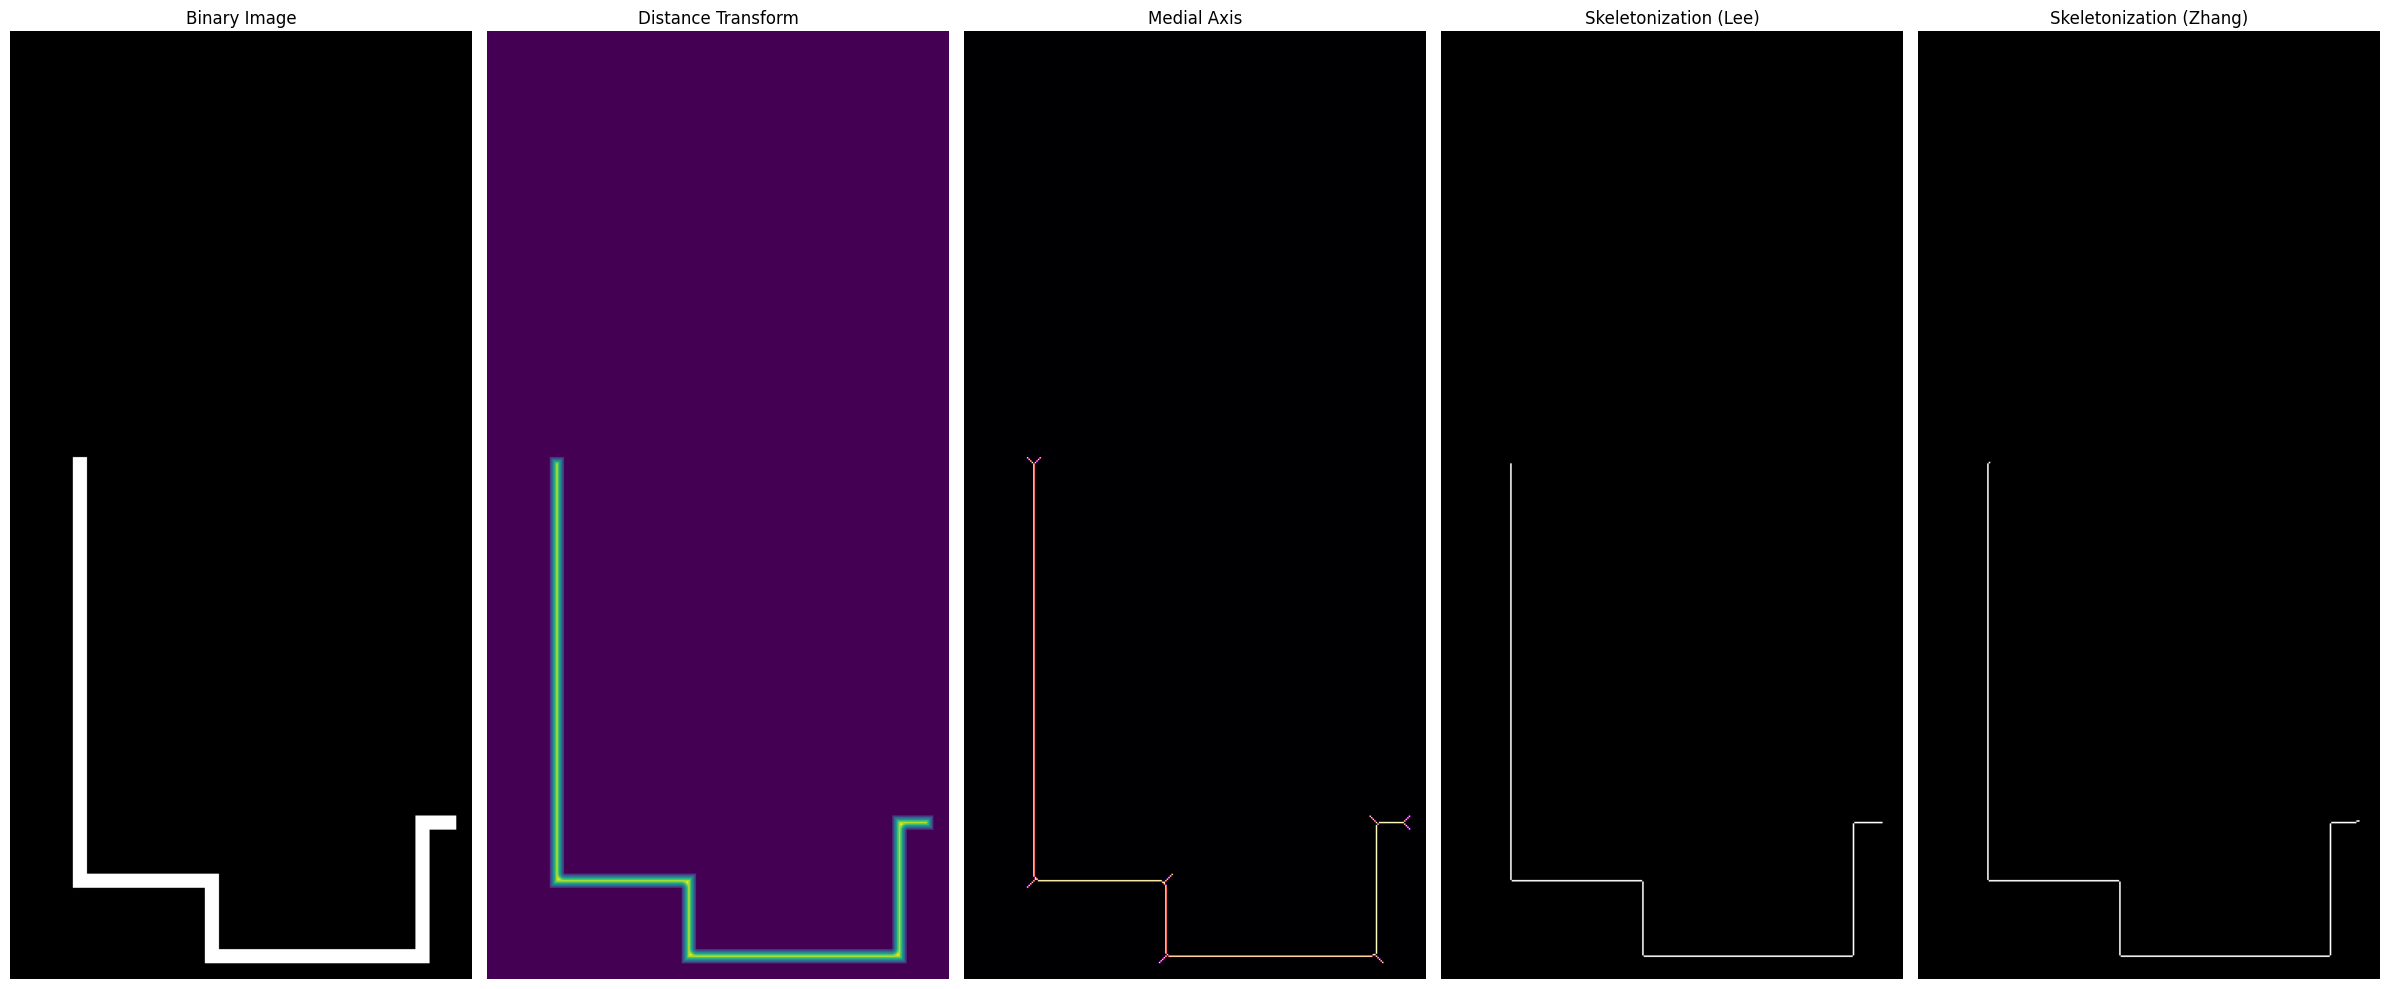

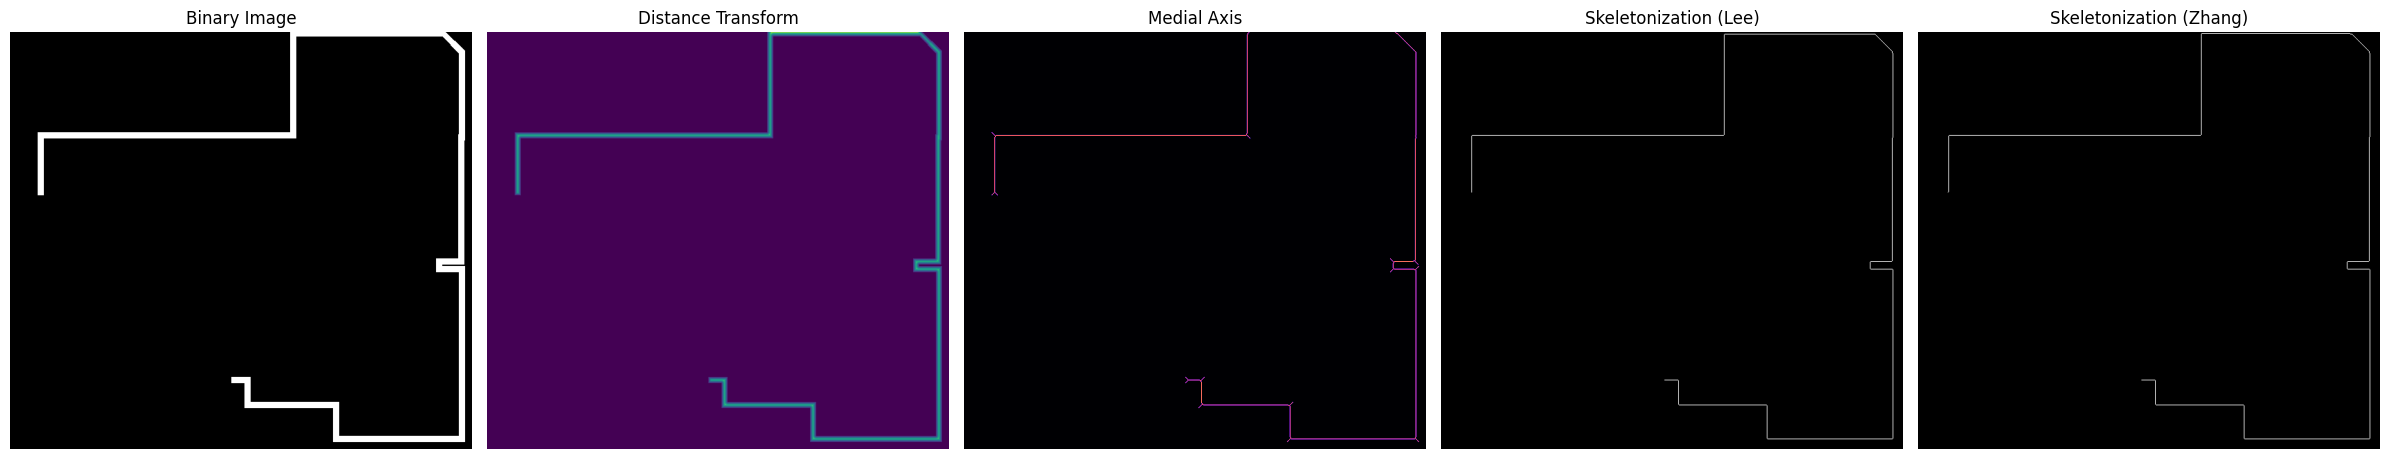

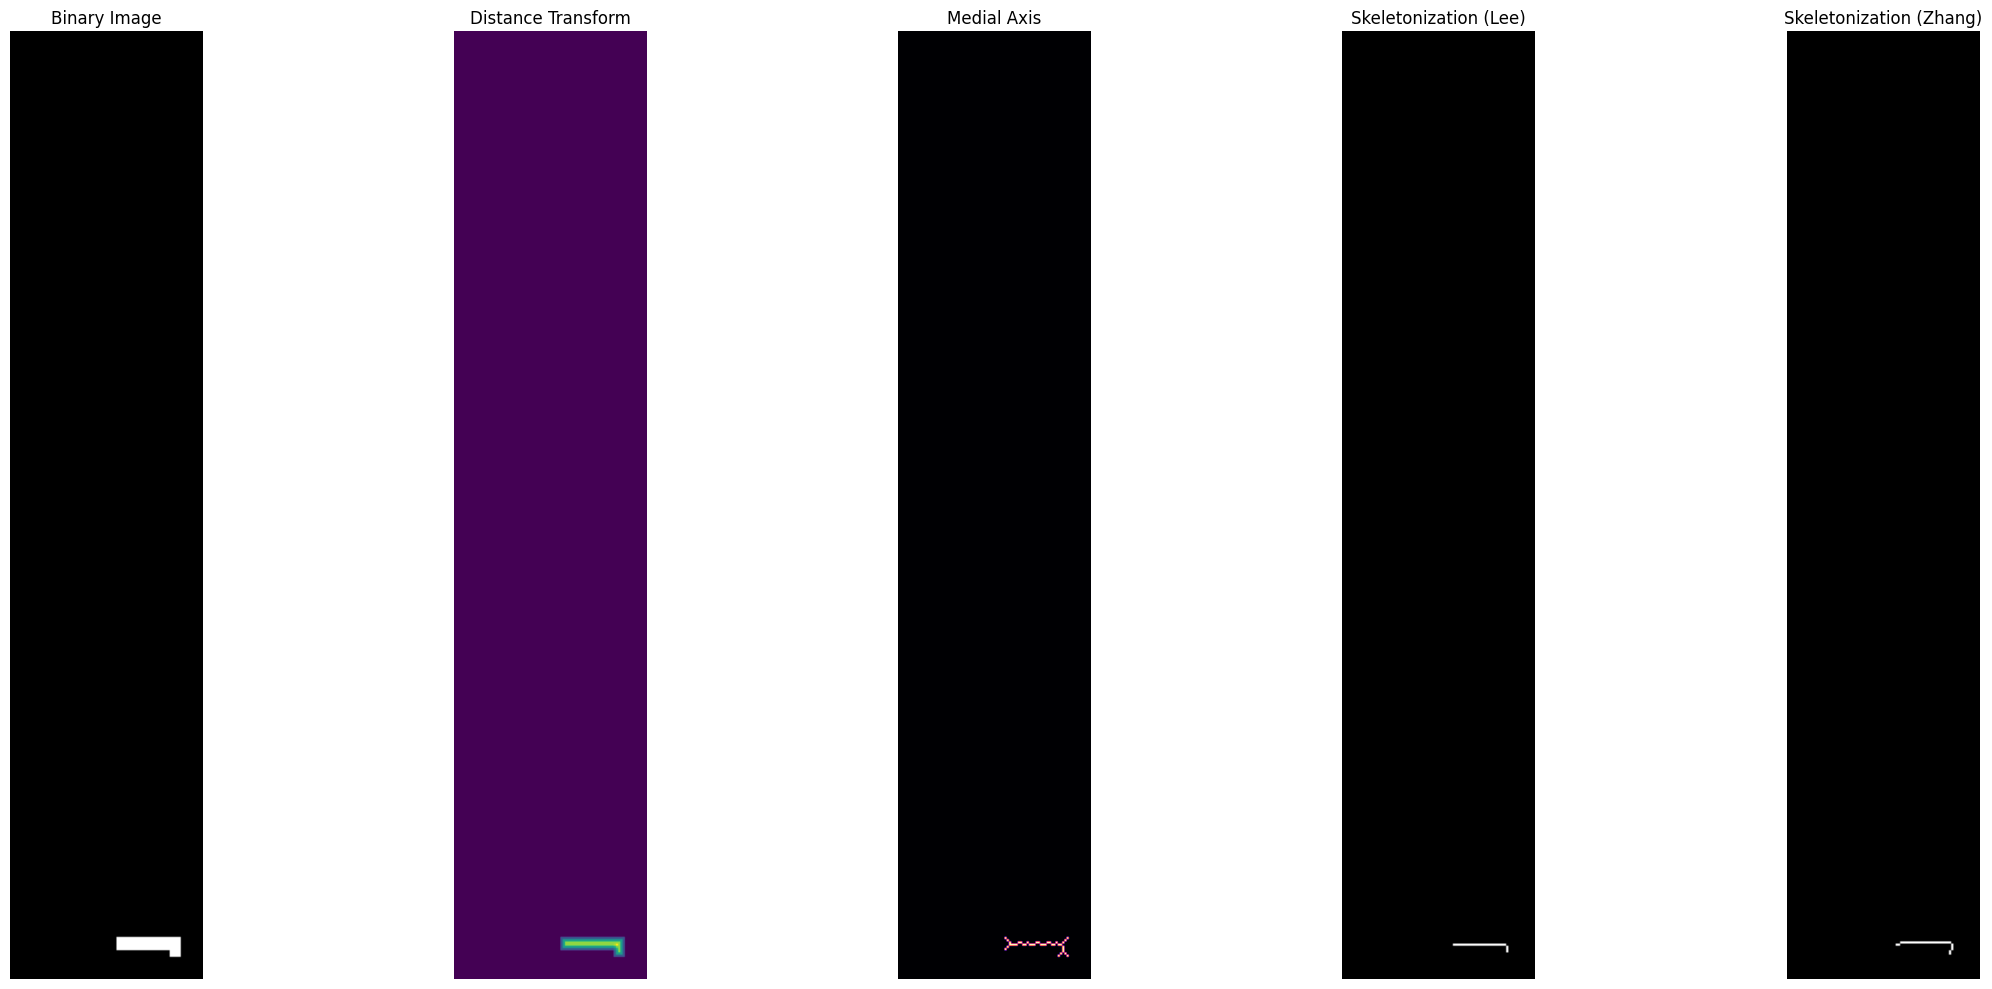

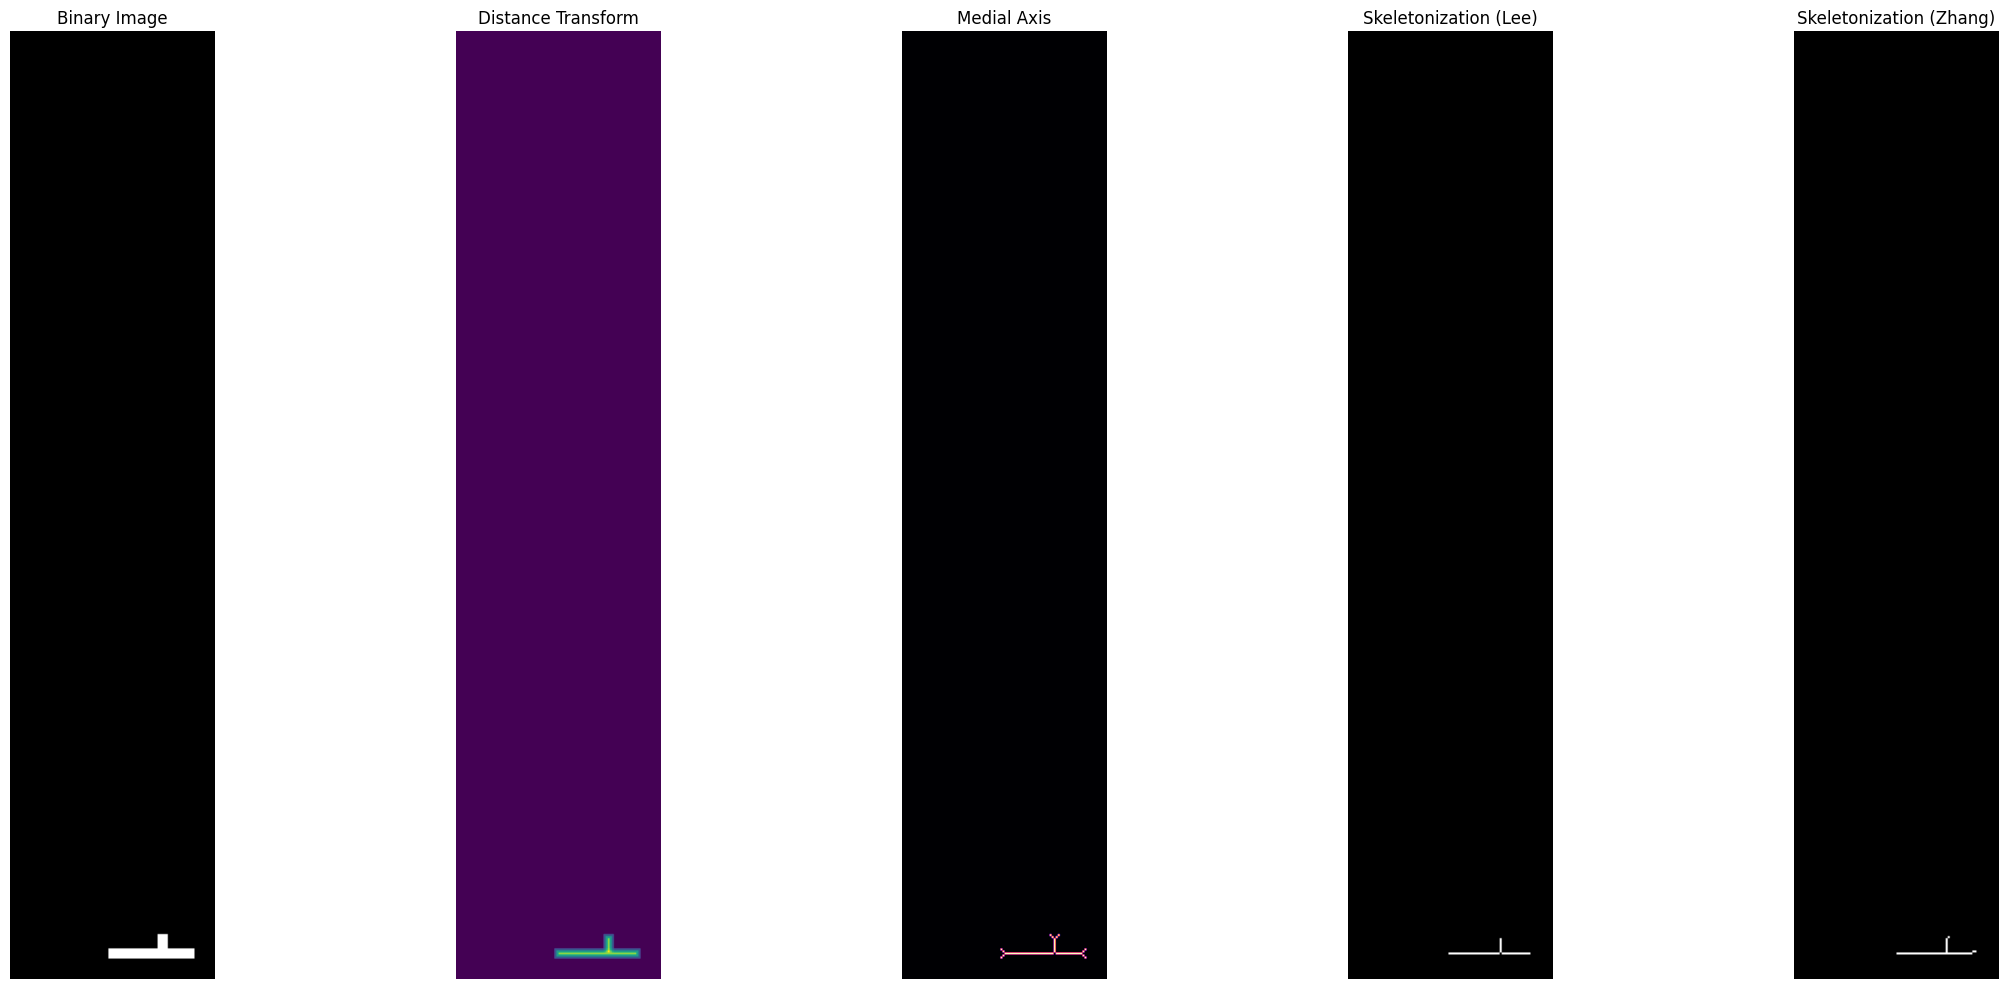

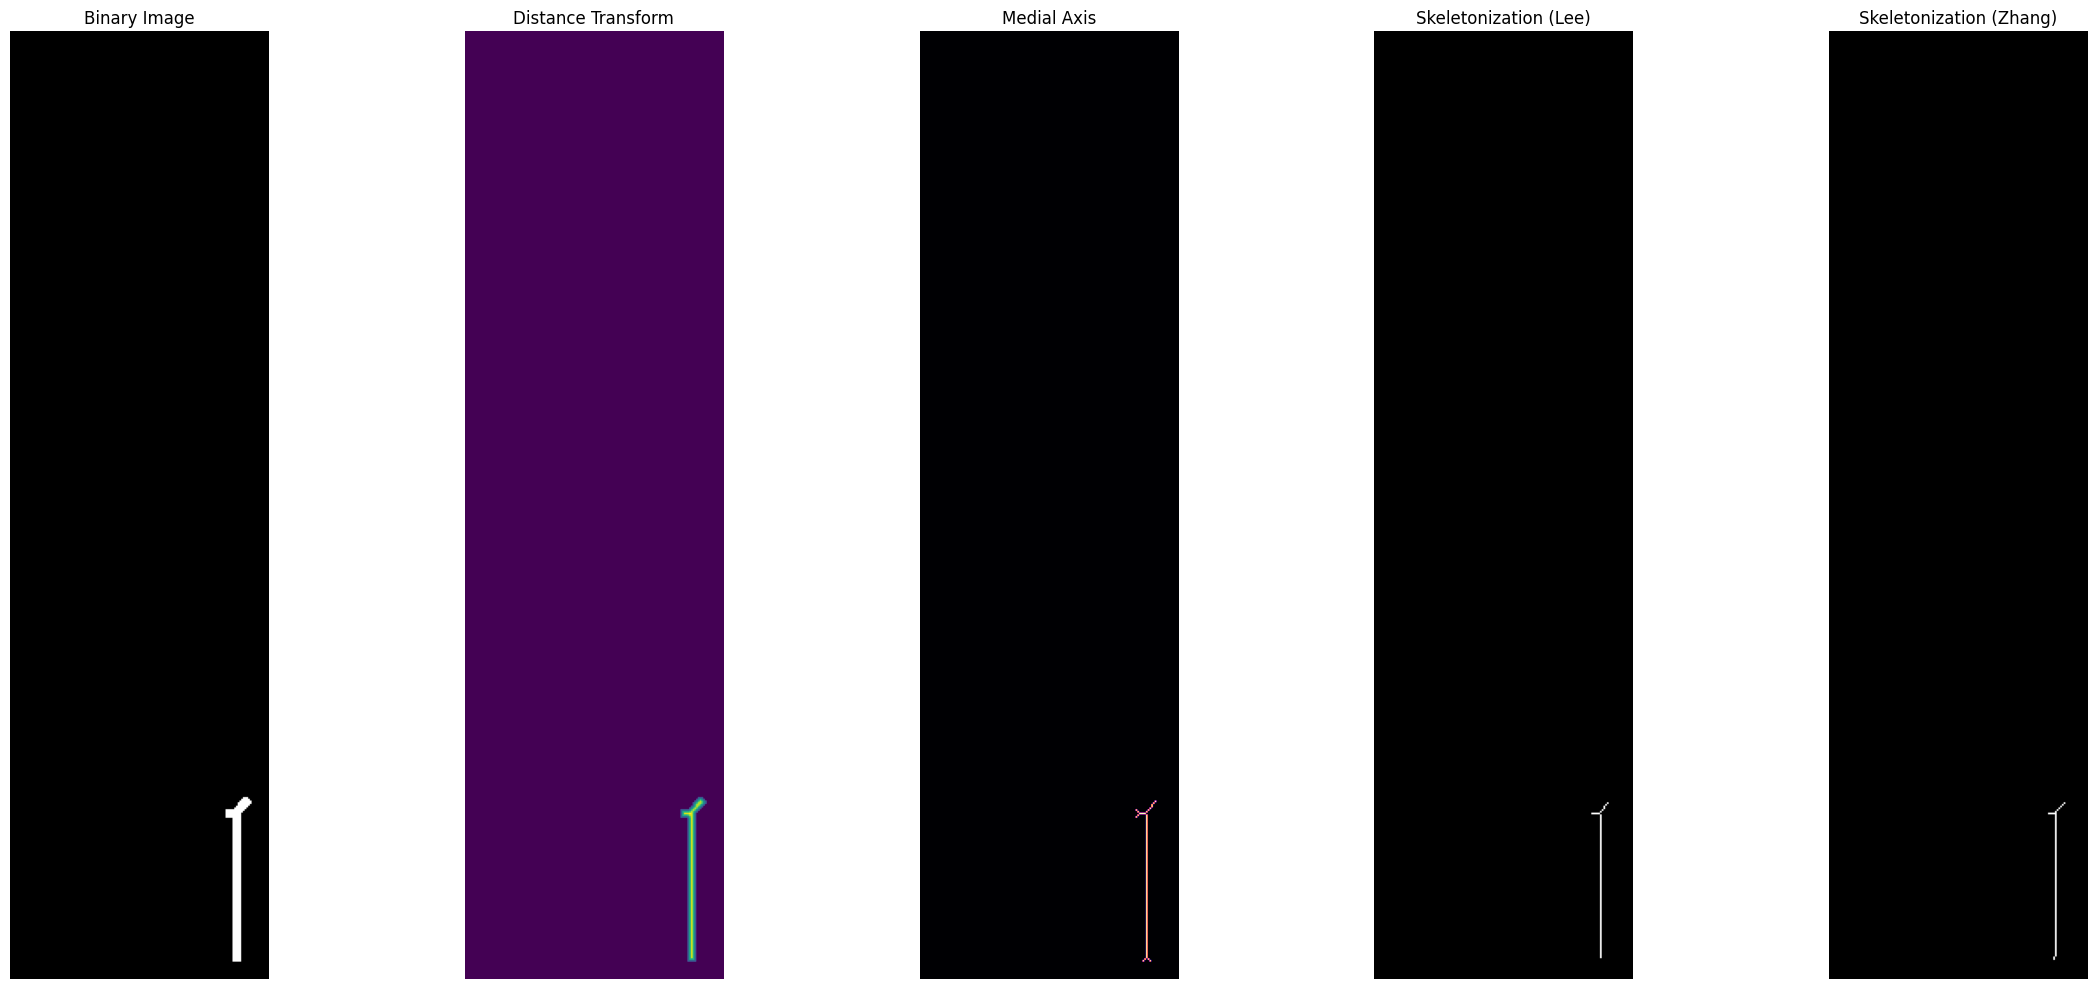

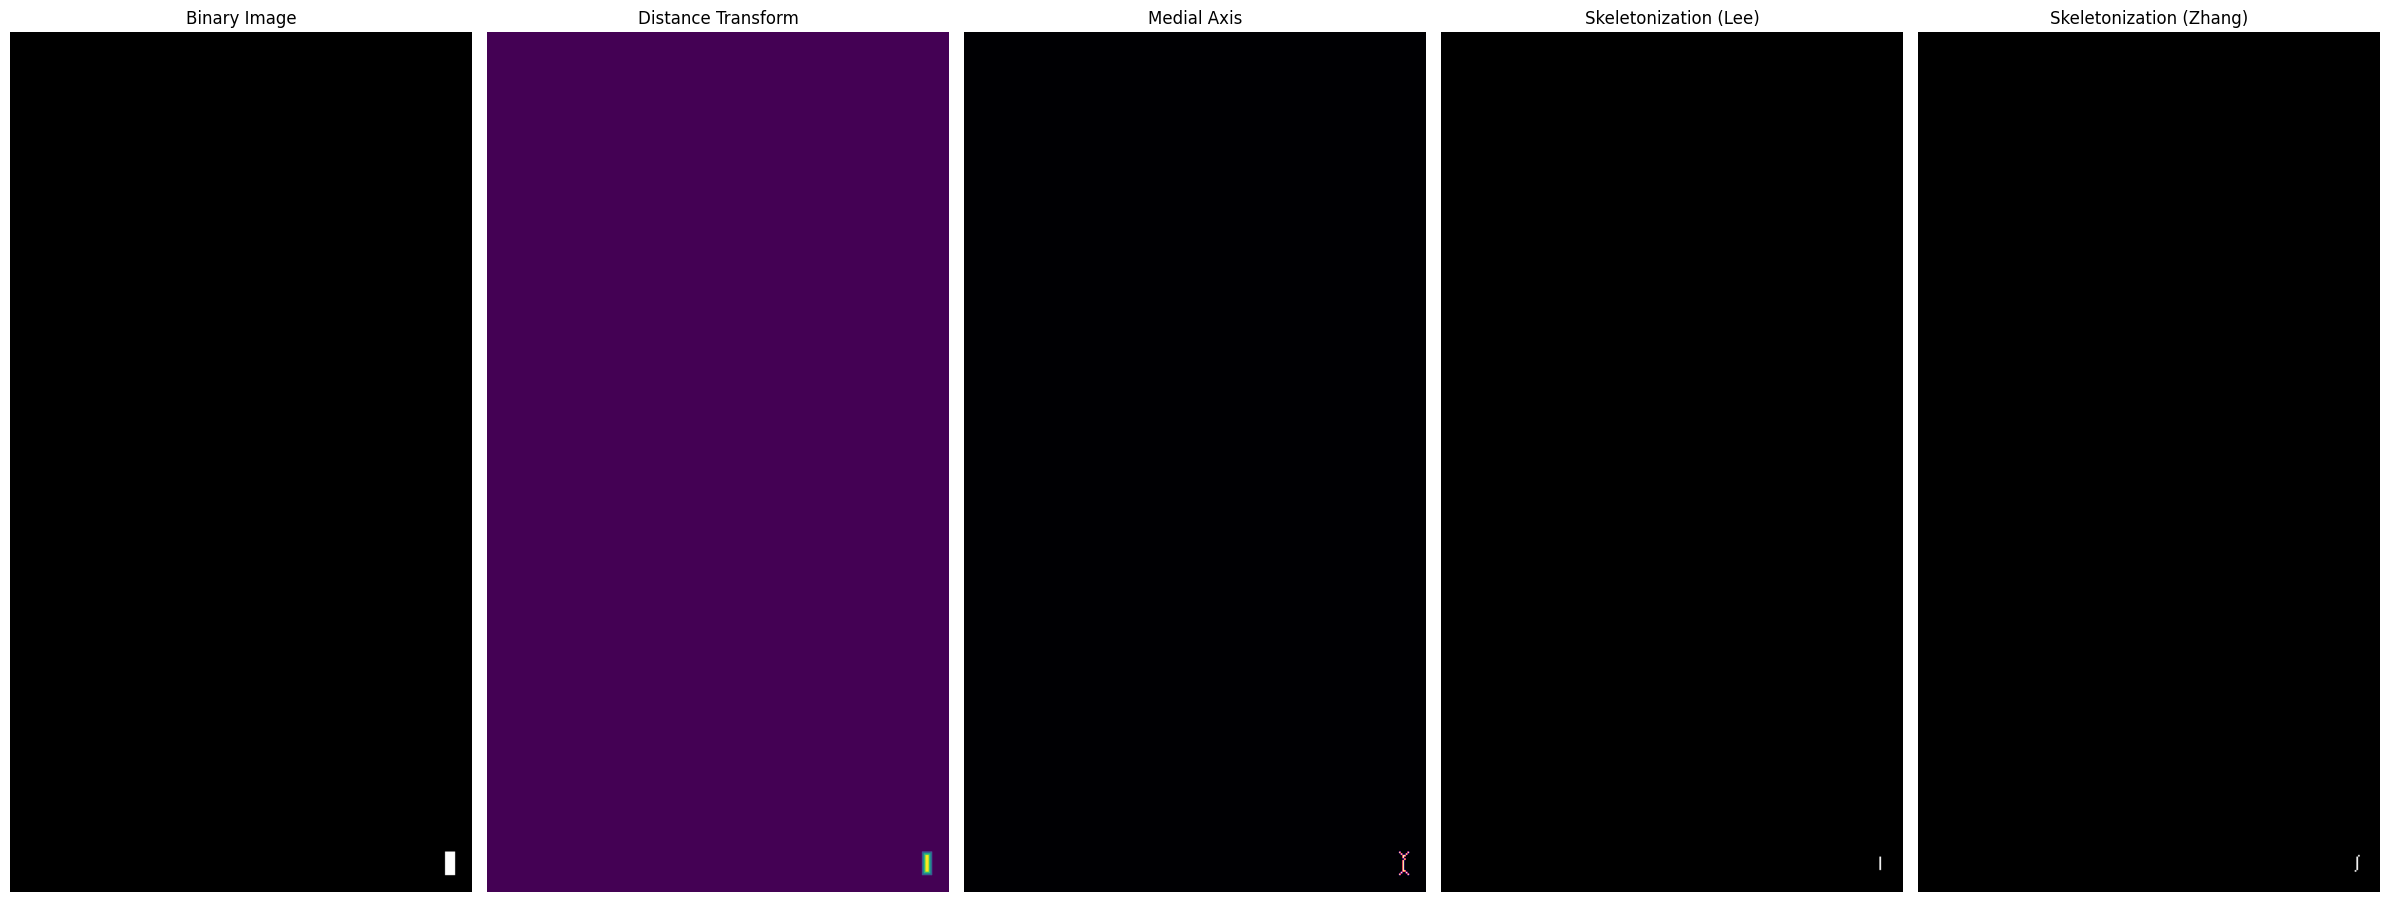

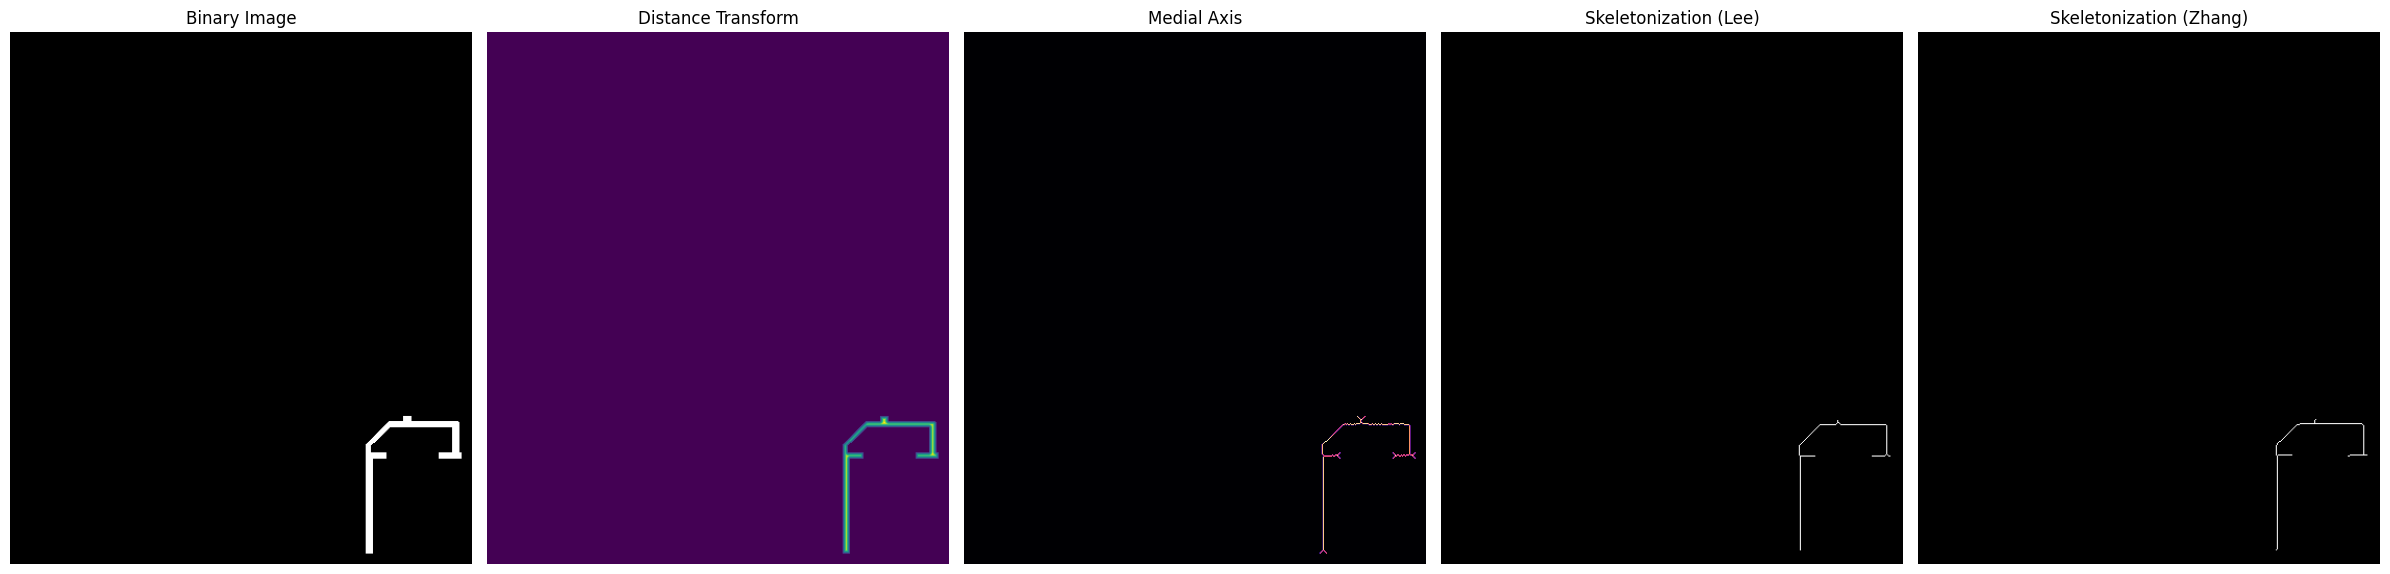

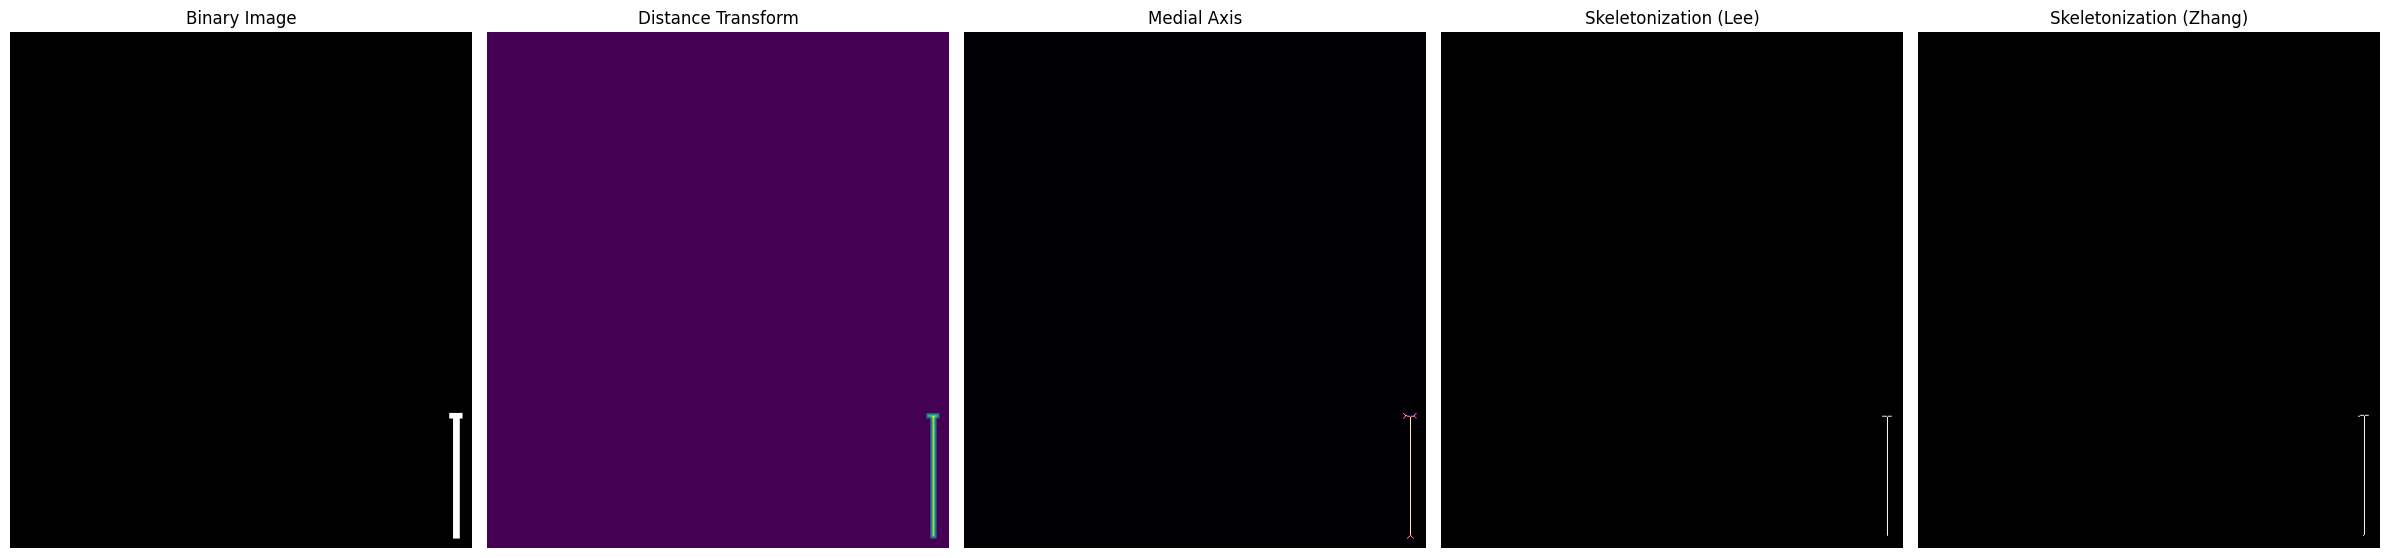

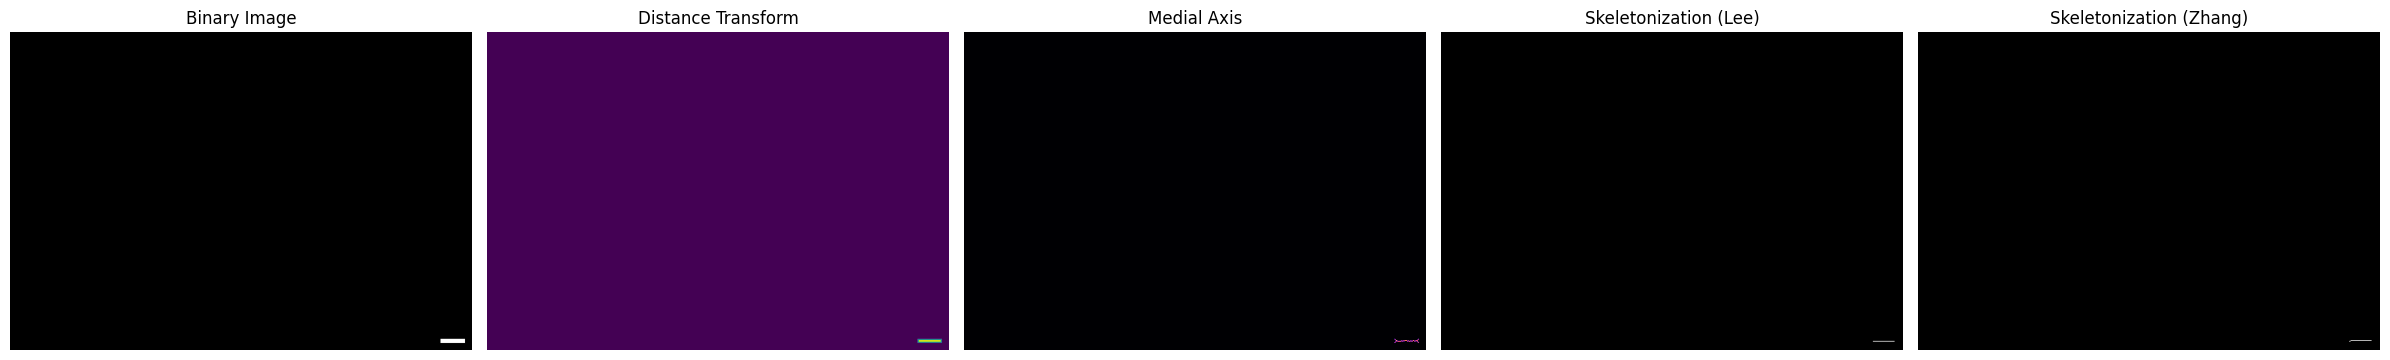

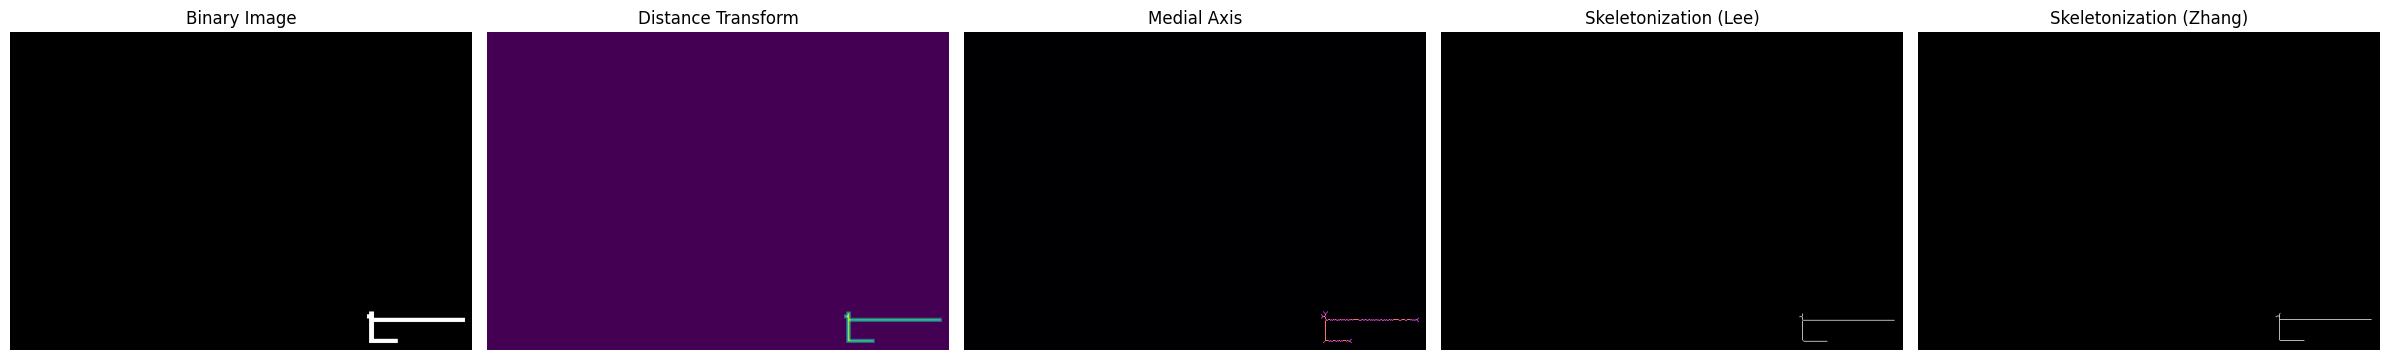

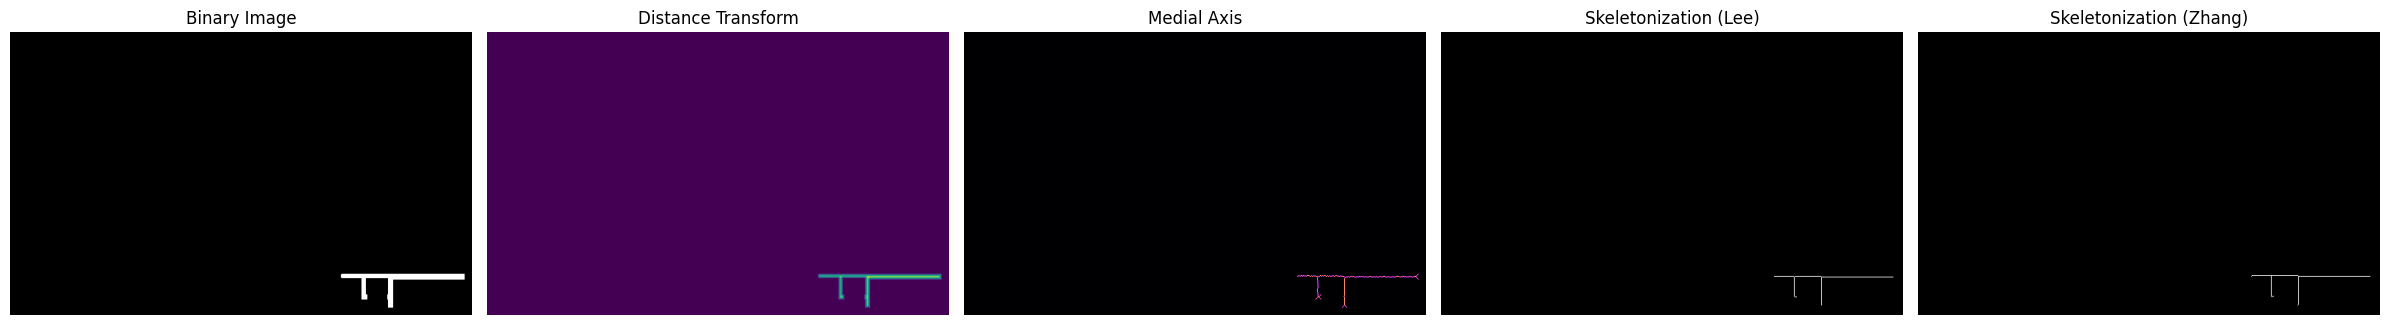

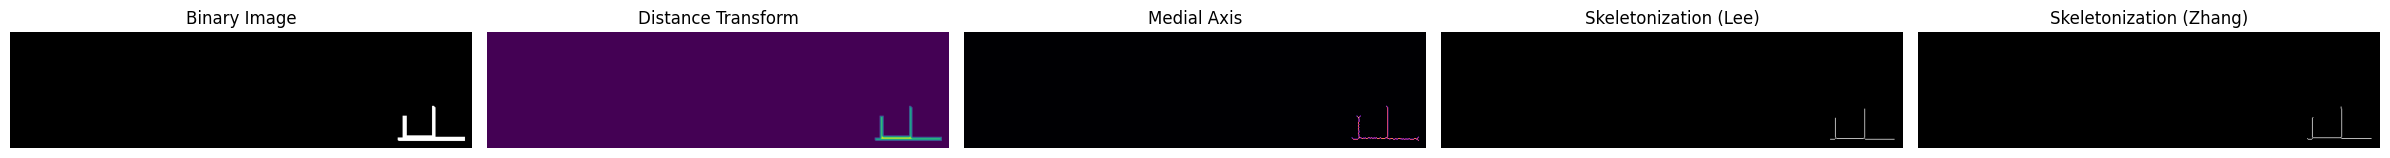

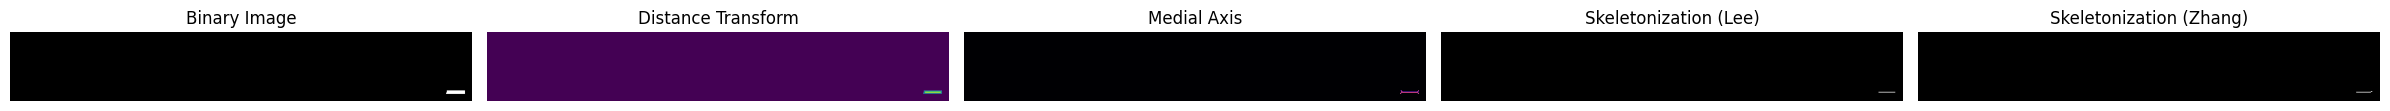

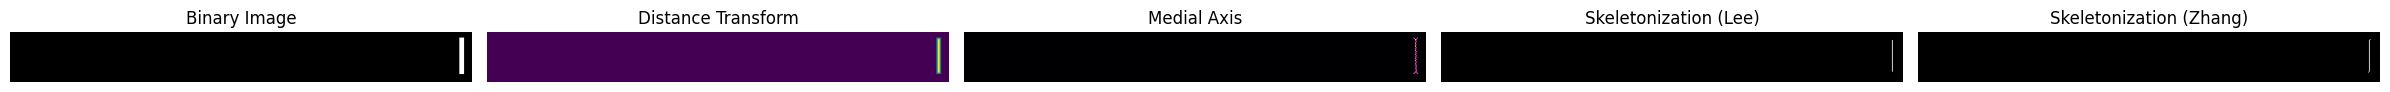

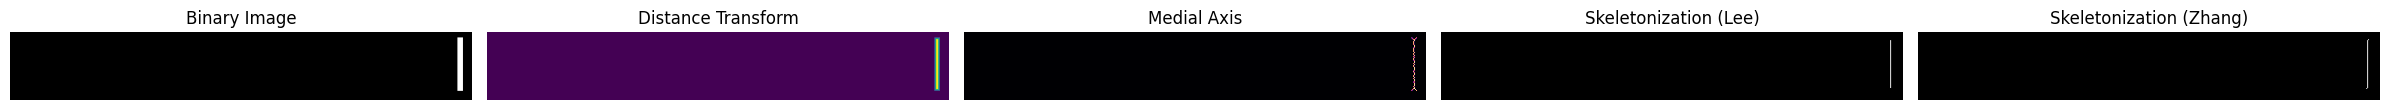

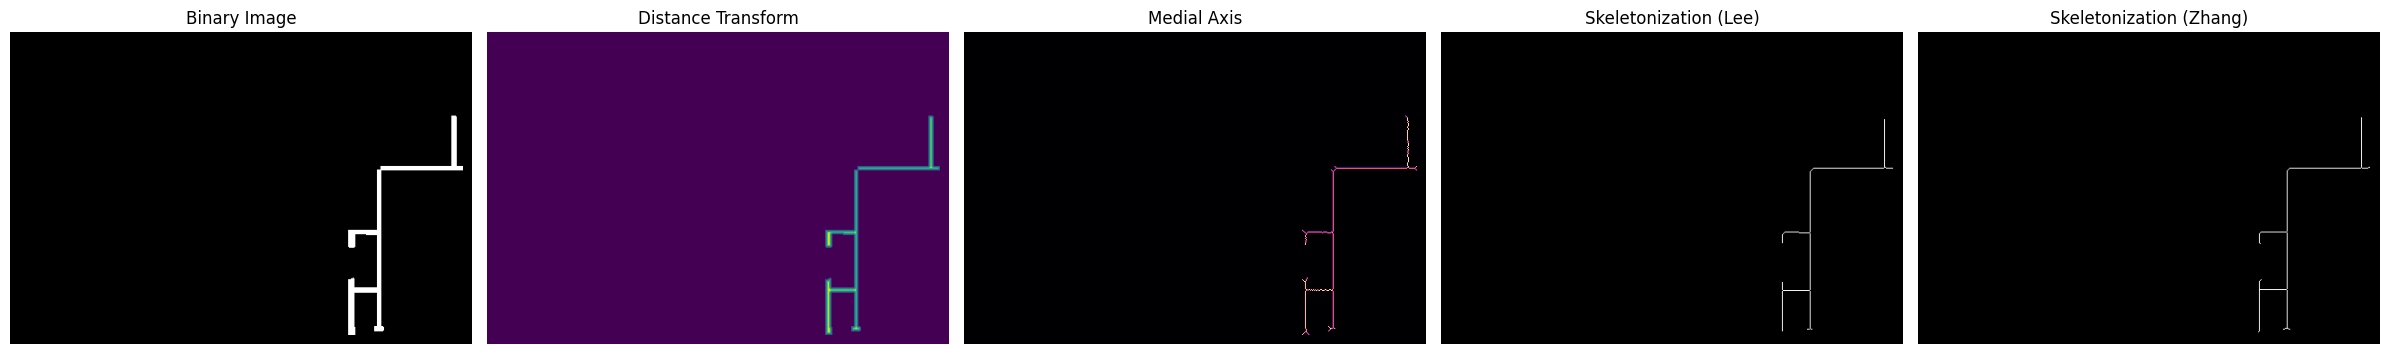

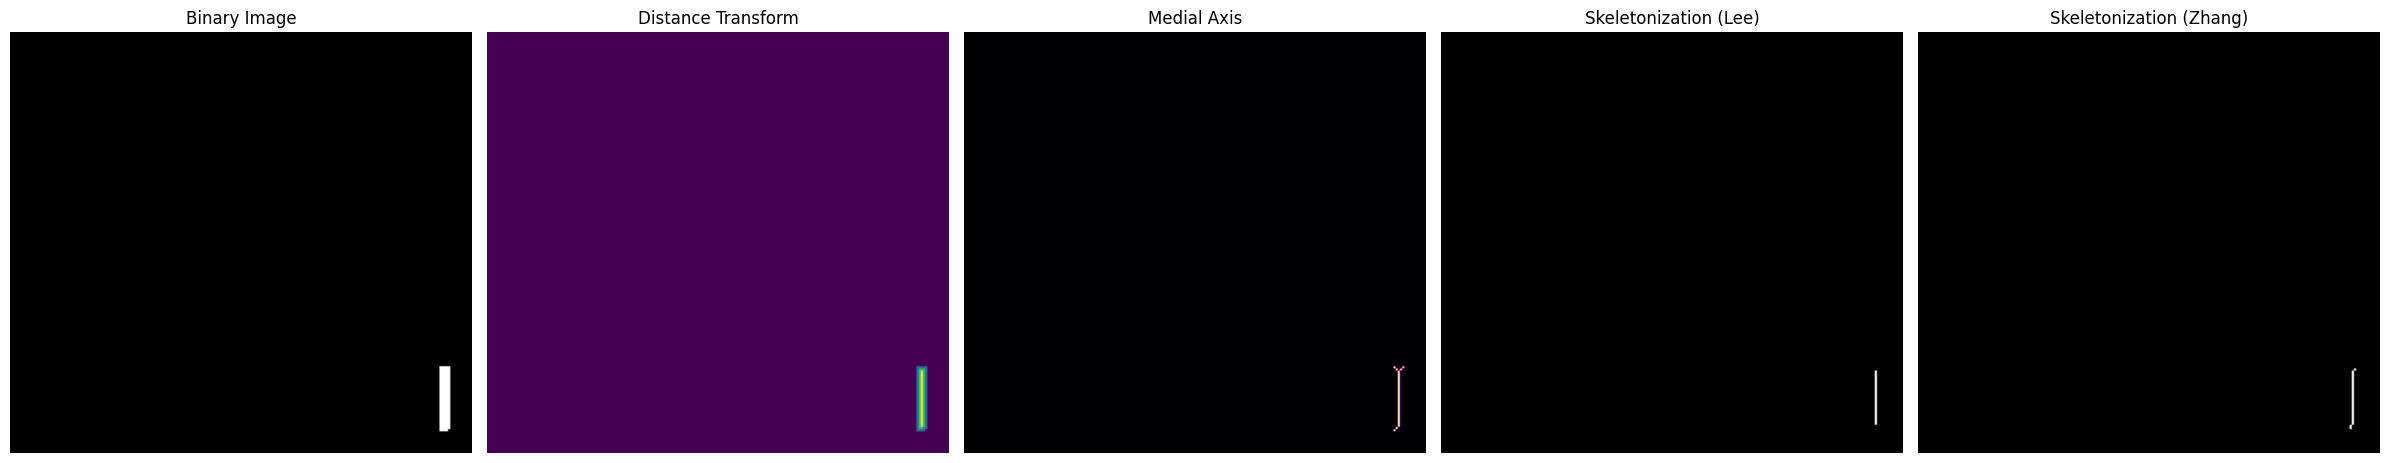

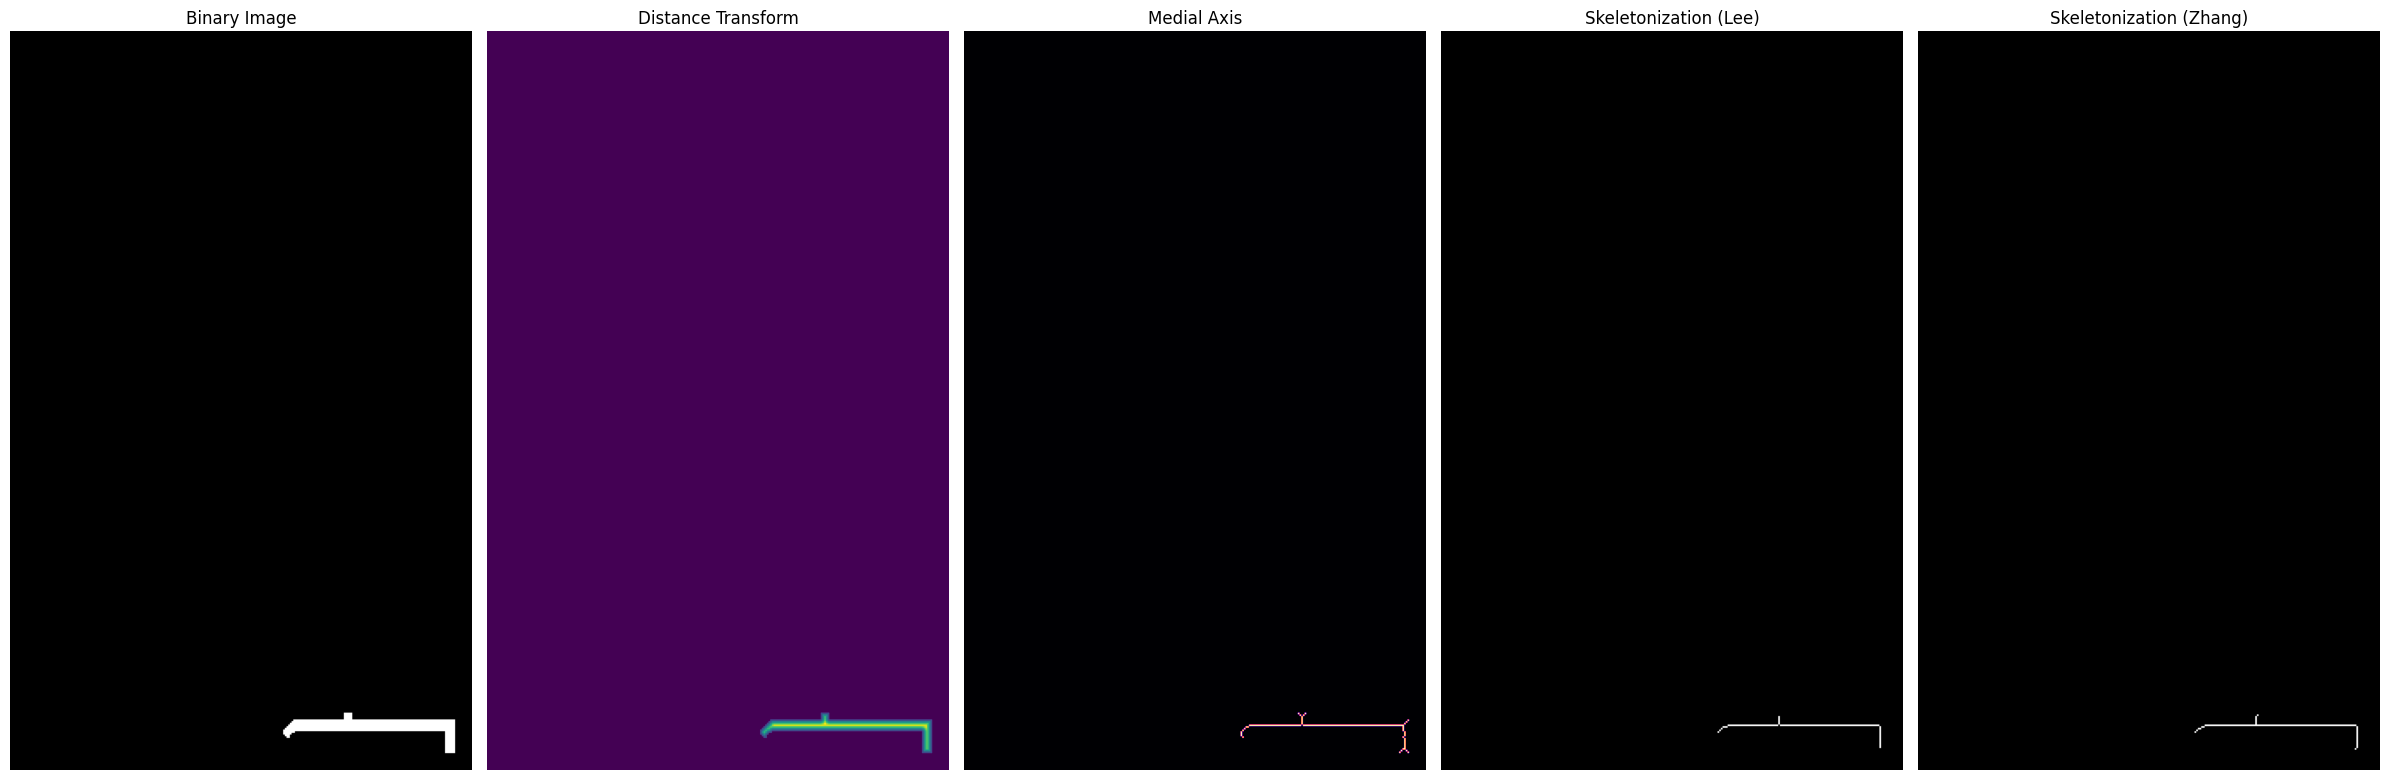

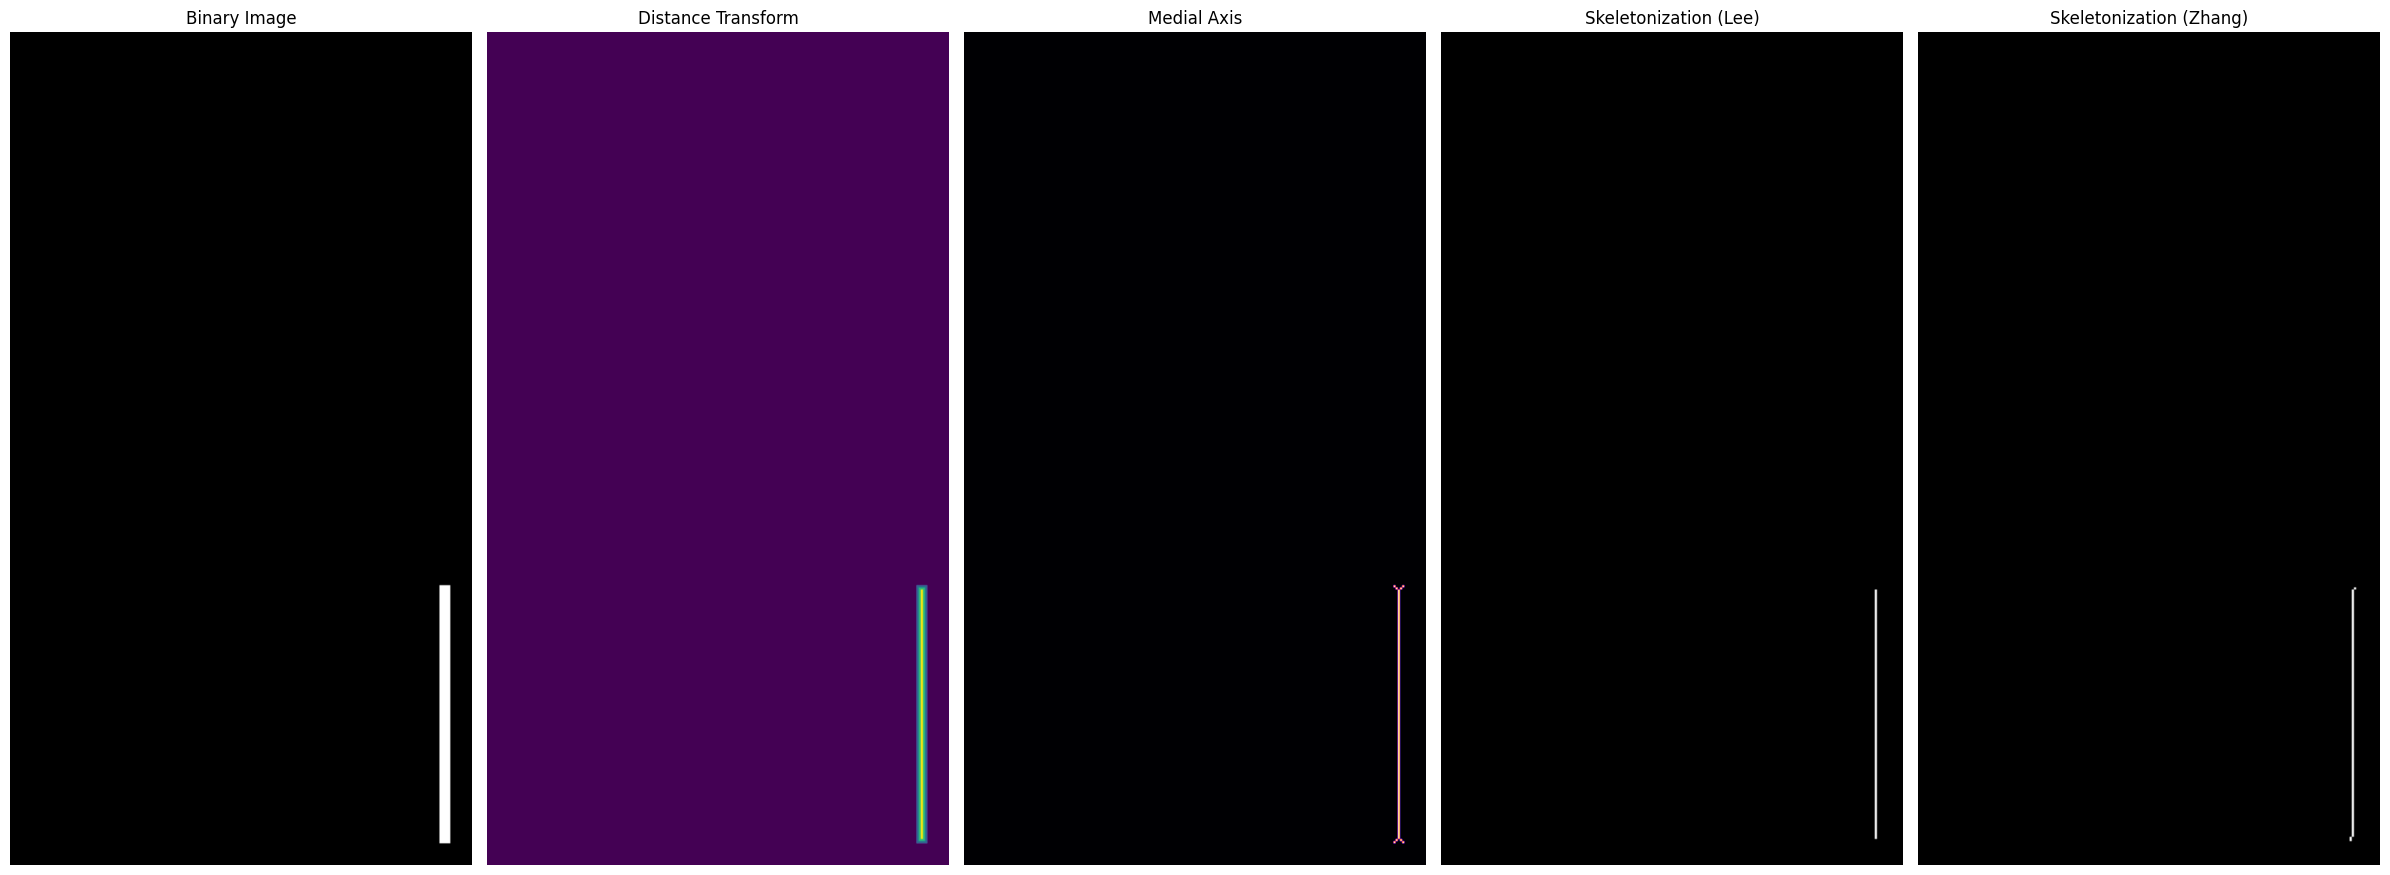

In [ ]:
paths = []

for wall_geometry in walls:
  image = draw_image(wall_geometry)

  # Compute the medial axis
  medial_axis_image, distances = medial_axis(image, return_distance=True)

  # Skeletonize the medial axis to ensure it is 1 pixel wide

  # Lee's method
  skeleton_lee = skeletonize(image, method='lee')

  # Zhang's method
  skeleton_zhang = skeletonize(image, method='zhang')

  points = np.column_stack(np.where(skeleton_lee))
  ordered_points = nearest_neighbor_kd_tree(points)

  strokes = format_segments_as_json(ordered_points, 2)
  paths.append(strokes)

  # Plotting the result
  fig, ax = plt.subplots(1, 5, figsize=(24, 10))
  ax[0].imshow(image, cmap='gray')
  ax[0].set_title('Binary Image')
  ax[0].axis('off')

  ax[1].imshow(distances, cmap='viridis')
  ax[1].set_title('Distance Transform')
  ax[1].axis('off')

  ax[2].imshow(medial_axis_image, cmap='magma')
  ax[2].set_title('Medial Axis')
  ax[2].axis('off')

  ax[3].imshow(skeleton_lee, cmap=plt.cm.gray)
  ax[3].set_title('Skeletonization (Lee)')
  ax[3].axis('off')

  ax[4].imshow(skeleton_zhang, cmap=plt.cm.gray)
  ax[4].set_title('Skeletonization (Zhang)')
  ax[4].axis('off')

  fig.tight_layout()
  plt.show()


In [ ]:
flattened_list = [item for sublist in paths for item in sublist]
print(flattened_list)

[{'type': 'segment', 'p1': {'x': 44, 'y': 275}, 'p2': {'x': 44, 'y': 276}}, {'type': 'segment', 'p1': {'x': 44, 'y': 276}, 'p2': {'x': 44, 'y': 277}}, {'type': 'segment', 'p1': {'x': 44, 'y': 277}, 'p2': {'x': 44, 'y': 278}}, {'type': 'segment', 'p1': {'x': 44, 'y': 278}, 'p2': {'x': 44, 'y': 279}}, {'type': 'segment', 'p1': {'x': 44, 'y': 279}, 'p2': {'x': 44, 'y': 280}}, {'type': 'segment', 'p1': {'x': 44, 'y': 280}, 'p2': {'x': 44, 'y': 281}}, {'type': 'segment', 'p1': {'x': 44, 'y': 281}, 'p2': {'x': 44, 'y': 282}}, {'type': 'segment', 'p1': {'x': 44, 'y': 282}, 'p2': {'x': 44, 'y': 283}}, {'type': 'segment', 'p1': {'x': 44, 'y': 283}, 'p2': {'x': 44, 'y': 284}}, {'type': 'segment', 'p1': {'x': 44, 'y': 284}, 'p2': {'x': 44, 'y': 285}}, {'type': 'segment', 'p1': {'x': 44, 'y': 285}, 'p2': {'x': 44, 'y': 286}}, {'type': 'segment', 'p1': {'x': 44, 'y': 286}, 'p2': {'x': 44, 'y': 287}}, {'type': 'segment', 'p1': {'x': 44, 'y': 287}, 'p2': {'x': 44, 'y': 288}}, {'type': 'segment', 'p1'